In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [57]:
import trieste
import gpflow
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import math
from util import plotting

In [4]:
from trieste.objectives.multi_objectives import VLMOP2
from trieste.objectives.utils import mk_observer
from trieste.observer import OBJECTIVE
from trieste.data import Dataset
from trieste.models.gpflow.models import GPRStack
from trieste.models.gpflow.models import GaussianProcessRegression

from trieste.acquisition import BatchMonteCarloExpectedHypervolumeImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.bayesian_optimizer import BayesianOptimizer

In [5]:
from trieste.acquisition.multi_objective.pareto import Pareto, get_reference_point

In [15]:
search_space = trieste.space.Box([0], [2*math.pi])

def f1(x):
    return tf.cos(2 * x) + tf.sin(x)

def f2(x):
    return 0.2 * (tf.cos(x) - tf.sin(x)) + 0.3

def f(x):
    return tf.concat([f1(x), f2(x)], axis=-1)

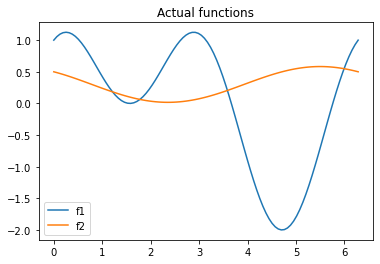

In [45]:
x_plot = np.linspace(start=search_space.lower[0], stop=search_space.upper[0], num=100)

plt.plot(x_plot, f1(x_plot), label="f1");
plt.plot(x_plot, f2(x_plot), label="f2");
plt.legend();
plt.title("Actual functions");
plt.show();

In [37]:
def build_stacked_independent_objectives_model(data: Dataset):
    gprs = []
    for idx in range(2):
        single_obj_data = Dataset(
            data.query_points, tf.gather(data.observations, [idx], axis=1)
        )
        variance = tf.math.reduce_variance(single_obj_data.observations)
        kernel = gpflow.kernels.Matern52(variance, tf.constant(0.2, tf.float64))
        gpr = gpflow.models.GPR(single_obj_data.astuple(), kernel, noise_variance=1e-5)
        gpflow.utilities.set_trainable(gpr.likelihood, False)
        gprs.append((GaussianProcessRegression(gpr), 1))

    return GPRStack(*gprs)

In [38]:
observer = mk_observer(f, OBJECTIVE)

In [39]:
initial_query_points = search_space.sample(10)
initial_data = observer(initial_query_points)

In [40]:
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

In [41]:
num_steps = 3
num_query_points=4

acq_function = BatchMonteCarloExpectedHypervolumeImprovement(sample_size=250).using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)

In [46]:
result = BayesianOptimizer(observer, search_space).optimize(num_steps, initial_data, {OBJECTIVE: model}, acq_rule)
dataset = result.try_get_final_datasets()[OBJECTIVE]

2021-11-26 14:33:47.785511: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-11-26 14:33:51.040231: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-11-26 14:33:55.050801: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9


Optimization completed without errors


In [51]:
models = result.try_get_final_models()[OBJECTIVE]._models

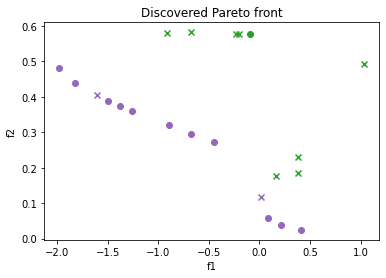

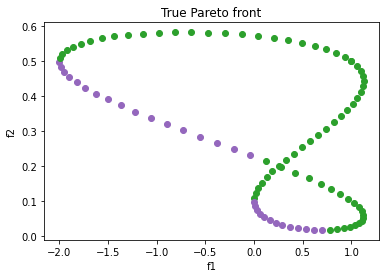

In [55]:
all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=len(initial_query_points))
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("Discovered Pareto front");
plt.show();



points_in_objective_space = tf.stack([f1(x_plot), f2(x_plot)], axis=-1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=0)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("True Pareto front");
plt.show();

In [58]:
from trieste.acquisition.function.local_penalization import MOLocalPenalizationAcquisitionFunction

In [63]:
acq_function = MOLocalPenalizationAcquisitionFunction().using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

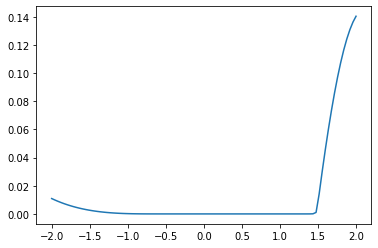

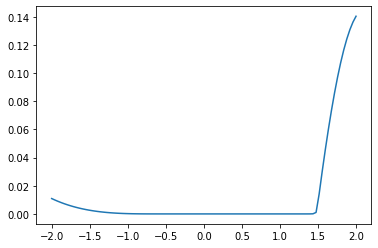


Optimization failed at step 0, encountered error with traceback:
Traceback (most recent call last):
  File "/home/andrei.paleyes/projects/trieste_stuff/trieste/trieste/bayesian_optimizer.py", line 374, in optimize
    self._search_space, models, datasets=datasets
  File "/home/andrei.paleyes/projects/trieste_stuff/trieste/trieste/acquisition/rule.py", line 239, in acquire
    chosen_point = self._optimizer(search_space, self._acquisition_function)
  File "/home/andrei.paleyes/projects/trieste_stuff/trieste/trieste/acquisition/optimizer.py", line 86, in automatic_optimizer_selector
    return generate_continuous_optimizer(num_samples)(space, target_func)
  File "/home/andrei.paleyes/projects/trieste_stuff/trieste/trieste/acquisition/optimizer.py", line 257, in optimize_continuous
    """
trieste.acquisition.optimizer.FailedOptimizationError: 
                    Acquisition function optimization failed,
                    even after 6 restarts.
                    

Terminating optimi

FailedOptimizationError: 
                    Acquisition function optimization failed,
                    even after 6 restarts.
                    

In [64]:
dataset = (BayesianOptimizer(observer, search_space)
        .optimize(2, initial_data, {OBJECTIVE: model}, acq_rule)
        .try_get_final_datasets()[OBJECTIVE])

In [ ]:
ref_point = get_reference_point(dataset.observations)

obs_hv = Pareto(dataset.observations).hypervolume_indicator(ref_point)
ideal_pf = tf.cast(VLMOP2().gen_pareto_optimal_points(100), dtype=tf.float64)
ideal_hv = Pareto(ideal_pf).hypervolume_indicator(ref_point)

print(tf.math.log(ideal_hv - obs_hv) < convergence_threshold)